<h1 style="text-align: center; "><strong>Dataset Collection</strong></h1>
<h3 style="text-align: center; "></h3>

### ***Tools*** <a class="anchor"  id="chapter4"></a>

#### ***Framework Selection*** <a class="anchor"  id="chapter4_1"></a>


- **Model Development**: Keras is used as a high-level interface for building, customizing, and training artificial neural network models. Keras provides an easy-to-use and intuitive API, which allows developers to quickly define model architecture, add layers, and configure model training.
- **Pre-trained Models**: In this project, a pre-trained VGG16, VGG19, ResNet50 model architecture are used. Keras provides various pre-trained models that have been trained on large datasets such as ImageNet. This allows developers to easily use a robust and proven model architecture, and utilize features that have been learned from large datasets.
- **Model Training**: TensorFlow acts as a computational backend for Keras. When Keras models are compiled and trained, TensorFlow manages the computations corresponding to the model definition, performs training by updating weights and biases through optimization algorithms such as Adam, and calculates evaluation metrics such as loss and accuracy.
- **Prediction and Evaluation**: Once the model is trained, Keras is used to make predictions on test images. Then, TensorFlow performs the computations required to process the input, run the model, and generate the predicted output. Furthermore, Keras and TensorFlow are used together to evaluate the performance of the model by comparing the model's predictions with the actual labels using evaluation metrics such as confusion matrix and classification report.
- **Confusion Matrix**: helps data analysts to understand the extent to which the model can correctly recognize and classify each category in the data.

#### ***Algorithm*** <a class="anchor"  id="chapter4_2"></a>

The task of image classification in the context of waste management, involved the primary consideration of three main **Convolutional Neural Network (CNN)** models: **VGG-16, VGG-19**, and **ResNet50**. The hypothesis underlying the selection of these models was that improved accuracy in waste classification would support the effectiveness of recycling programs. 

**References**
- Rismiyati, R., & Luthfiarta, A. (2021). Arsitektur Pembelajaran Transfer VGG16 untuk Klasifikasi Mutu Buah Salak.
- Telematika, 18(1), 37. Vaswani, A., & Balaji, A. (2021).A Review on Recent Architectures for Deep Learning-Based Image Classification. 2nd International Conference on Computing, Mathematics and Engineering Technologies (iCoMET). 
- Li, Z., Lin, J., Xu, L., Lu, Y., Xie, Y., & He, Z. (2021).Application of ResNet-50 in automatic classification of satellite remote sensing images. Journal of Applied Remote Sensing, 15(1), 016516.

## ***Implementation*** <a class="anchor"  id="chapter5"></a>

### ****Import library:**** <a class="anchor"  id="chapter2"></a>

Import necessary libraries from keras, image processing, and model validation (confusion matrix)

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install -q seaborn visualkeras
import visualkeras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go
from PIL import Image
import cv2
import os

import tensorflow as tf
from keras import layers
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Update
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## ****Data Collection:**** <a class="anchor" id="chapter2"></a>
### About the dataset <a class="anchor" id="subsection_2_1"></a>
- The data in this article is taken and mixed from two data on Kaggle:
  - Data 6 class `[trash, glass, plastic, organic, paper, cardboard]`: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
  - Additional data includes 12 classes `[battery, biological, white-glass, brown-glass, cardboard, clothes, green-glass, metal, paper, plastic, shoes, trash]`: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
- 12 class data from the link [Data 6 classes (link 1 above)](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification) initially includes **`[trash, glass, plastic , organic, paper, cardboard]`**. But the class **`trash`** causes interference in the model (it is easy to see that in this class there are also plastic bags that appear in the class **`plastic`** and food items that appear in the class **`organic`**.

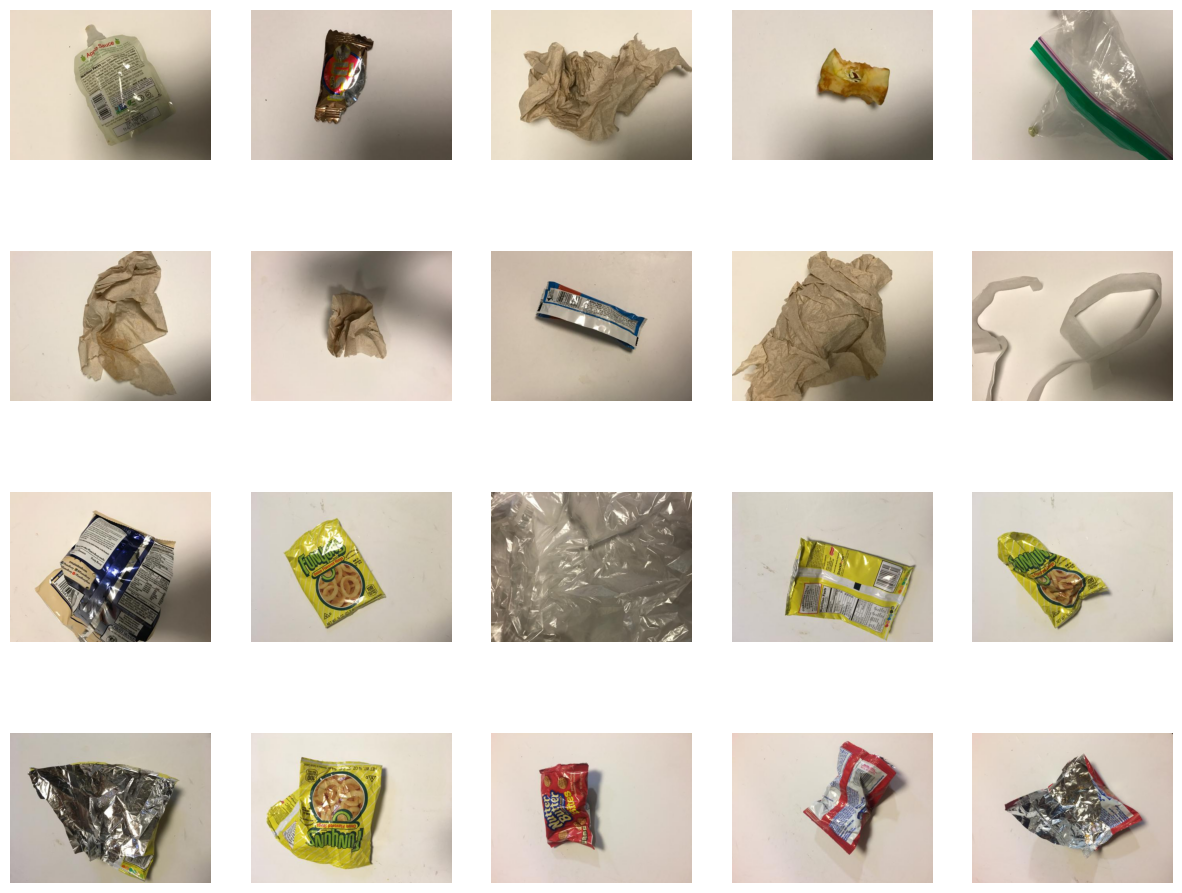

In [2]:
directory_path = "garbage_classification_6_classes/Garbage classification/trash"
image_files = sorted([file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])[:20]
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(directory_path, image_file))
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
plt.show()

Therefore, we must remove this class to avoid causing interference to the model. The **`trash`** class will now be replaced by the **`battery`** class added from [Data 12 classes (link 2 above)](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)

> 12 class data will not be used mainly but only to supplement 6 class data, due to:
> - The number of 12 classes is quite a lot for the number of classes needed in the problem to be solved.
> - In addition, the fact that Data 12 classes have too many interfering classes such as **`[green-glass, white-glass, brown-glass...]`** is unnecessary for the problem and puts pressure on the problem. performance and accuracy for the model.
> - The 12-class data is quite unbalanced in terms of quantity between classes (unbalanced data).

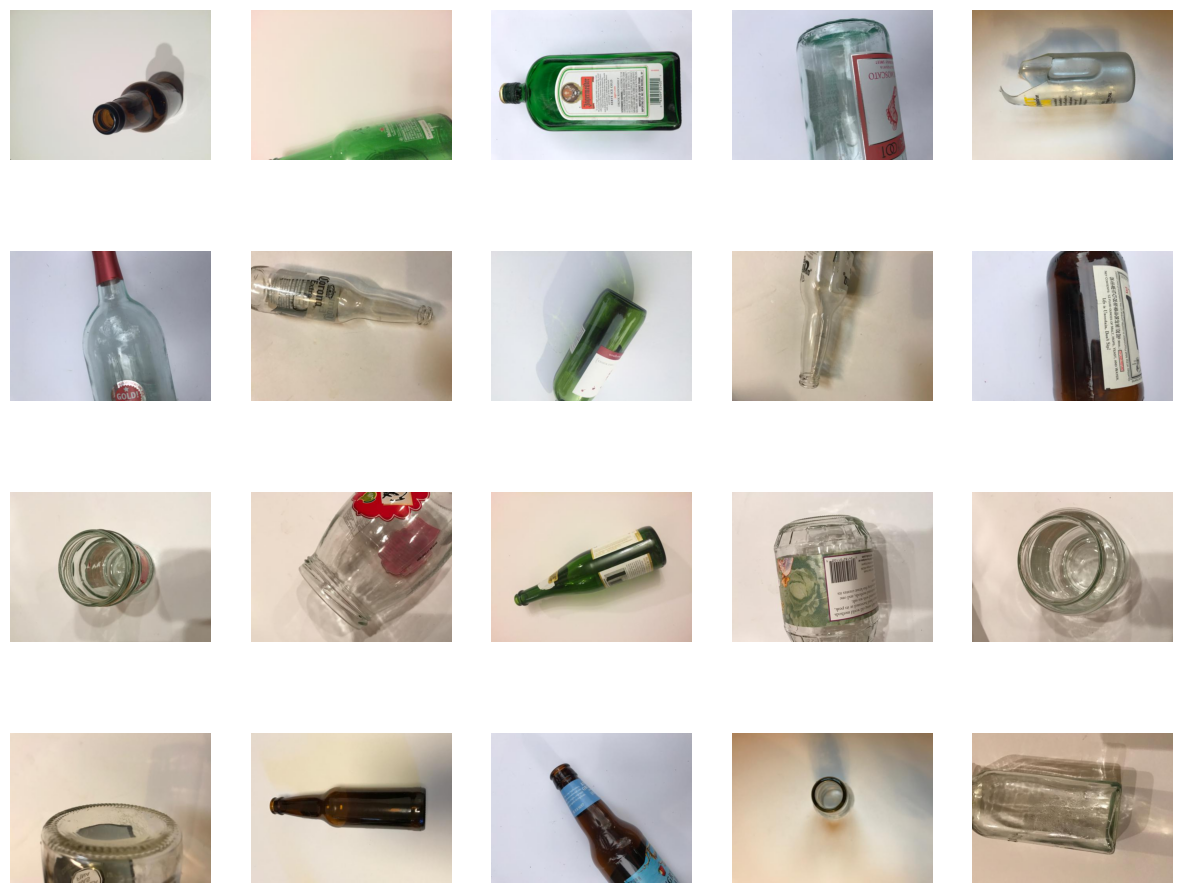

In [3]:
directory_path = "garbage_classification_6_classes/Garbage classification/glass"
image_files = sorted([file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])[:20]
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(directory_path, image_file))
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
plt.show()

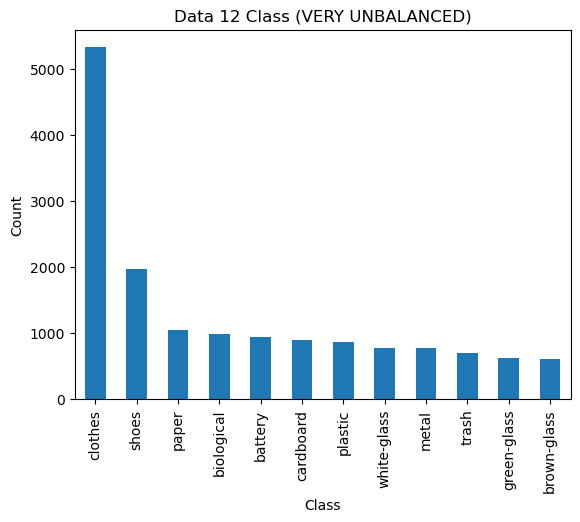

In [4]:
import os

root = 'garbage_classification'
data = {}

# Iterasi melalui setiap folder dalam root
for i in os.listdir(root):
    folder_path = os.path.join(root, i)
    
    # Pastikan folder_path adalah direktori (bukan file)
    if os.path.isdir(folder_path):
        # Iterasi melalui setiap file dalam folder
        for root_path, _, files in os.walk(folder_path):
            for file in files:
                # Pastikan file memiliki ekstensi gambar yang diizinkan
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    data[os.path.join(root_path, file)] = i

# Konversi ke DataFrame
data = pd.DataFrame(data.items(), columns=['path', 'class_'])

# Plot jumlah gambar per kelas
data['class_'].value_counts().plot(kind='bar')
plt.title('Data 12 Class (VERY UNBALANCED)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

* The team decided to use `white-glass` as the main data for the class `glass` in the new data set (to avoid confusion and interference with other classes such as metal, battery,...).

In [5]:
data[data['class_'] == 'white-glass']['class_'].value_counts()

white-glass    775
Name: class_, dtype: int64

> Because this `white-glass` class has 775 images, the team will use this number as a standard when mixing images from two data sets to make the data more balanced.

### Prepare dataset: <a class="anchor" id="subsection_2_2"></a>

> The team has filtered some classes (relabeled the data) and uploaded this dataset to drive.

   * Link to dataset: https://drive.google.com/file/d/1MUFbOvAPCIpgTK2yNJCf3u98wXO2zzpv/view?usp=sharing

The new data includes 6 classes **[metal, glass, organic, paper, battery, plastic]**, of which:
- The group chose the number 775 because this is the maximum size that can be added from both datasets so that the size of each class is equal.
- 3 classes **[metal, paper, plastic]** from base data ([data 6 original classes](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification)), if any class size 775 images are not enough, will be taken from ([data 12 class](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)) to supplement and fill up 775 images.
- 3 classes **[glass, battery, organic]** are collected entirely from one dataset: ([data 12 classes](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)), in which class **organic** is renamed from **biological**, class **glass** is renamed from **white-glass**.

### **Additional code and relabeling data:**

In [6]:
import os
import shutil

original_path = 'garbage_classification_6_classes/Garbage classification'
bonus_data_path = 'garbage_classification/'
destination_path = 'modified_dataset/'

if os.path.exists(destination_path) and os.path.isdir(destination_path):
    shutil.rmtree(destination_path)

os.makedirs(destination_path, exist_ok=True)
classes_to_remove = ['cardboard', 'trash', 'glass'] # in original data
new_classes = ['battery', 'biological', 'white-glass'] # in bonus data
target_image_count = 775

for class_name in os.listdir(original_path):
    class_path = os.path.join(original_path, class_name)

    if class_name in classes_to_remove:
        continue

    new_class_name = class_name
    if class_name in new_classes:
        new_class_name = new_classes[new_classes.index(class_name)]

    new_class_path = os.path.join(destination_path, new_class_name)
    os.makedirs(new_class_path, exist_ok=True)
    files_to_copy = os.listdir(class_path)[:target_image_count]
    for file_name in files_to_copy:
        file_path = os.path.join(class_path, file_name)
        shutil.copy(file_path, new_class_path)
    
    # If the class has fewer than target_image_count images, fill up from bonus data
    if len(os.listdir(new_class_path)) < target_image_count:
        remaining_images = target_image_count - len(os.listdir(new_class_path))
        print(f"{class_name} has {len(os.listdir(new_class_path))} images and missing {remaining_images} to fill {target_image_count}.")
        if class_name == "glass":
            bonus_class_path = os.path.join(bonus_data_path, "white-glass")
        else:
            bonus_class_path = os.path.join(bonus_data_path, class_name)
        if bonus_class_path:
            bonus_files = os.listdir(bonus_class_path)
            copied_names = set(os.listdir(new_class_path))
            for file_name in bonus_files:
                if remaining_images == 0:
                    break
                new_file_name = file_name
                counter = 1
                while new_file_name in copied_names:
                    base_name, extension = os.path.splitext(file_name)
                    new_file_name = f"{class_name}_{counter}{extension}"
                    counter += 1
                file_path = os.path.join(bonus_class_path, file_name)
                new_file_path = os.path.join(new_class_path, new_file_name)
                shutil.copy(file_path, new_file_path)
                copied_names.add(new_file_name)
                remaining_images -= 1

# Process the bonus dataset to copy battery and organic data
for class_name in os.listdir(bonus_data_path):
    class_path = os.path.join(bonus_data_path, class_name)
    if class_name in new_classes:
        new_class_name = class_name
        if class_name in new_classes:
            new_class_name = new_classes[new_classes.index(class_name)]
        if new_class_name == "biological":
            new_class_path = os.path.join(destination_path, "organic")
        elif new_class_name == "white-glass":
            new_class_path = os.path.join(destination_path, "glass")
        else:
            new_class_path = os.path.join(destination_path, new_class_name)
        os.makedirs(new_class_path, exist_ok=True)
        files_to_copy = os.listdir(class_path)[:target_image_count]
        for file_name in files_to_copy:
            file_path = os.path.join(class_path, file_name)
            shutil.copy(file_path, new_class_path)

print("\nFINISH: Dataset modification complete.")
for class_ in os.listdir(destination_path):
    count_class = len(os.listdir(os.path.join(destination_path, class_)))
    print(f"{class_} has {count_class} images.")


metal has 410 images and missing 365 to fill 775.
paper has 594 images and missing 181 to fill 775.
plastic has 482 images and missing 293 to fill 775.

FINISH: Dataset modification complete.
battery has 775 images.
glass has 775 images.
metal has 775 images.
organic has 775 images.
paper has 775 images.
plastic has 775 images.


## ****Explore Data Analysis (EDA):**** <a class="anchor" id="chapter3"></a>
- First of all, we will start exploring the data to get an overview and understand the structure and properties of the data set. Thereby, we will have a basis to continue taking the next steps to solve the problem.

In [7]:
data_path = 'modified_dataset'
data_classes = os.listdir(data_path)
data_classes

['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']

- In this new dataset, images will belong to main groups including: `metal`, `glass`, `organic`, `paper`, `battery`, and `plastic`.

In [8]:
for class_ in os.listdir(data_path):
    count_class = 0
    class_path = os.path.join(data_path, class_)
    for photo in os.listdir(class_path):
        count_class += 1
    print(str(class_) + " has " + str(count_class) + " images.")

battery has 775 images.
glass has 775 images.
metal has 775 images.
organic has 775 images.
paper has 775 images.
plastic has 775 images.


- At this time, the dataset includes 6 data classes, each with 775 images.
- To facilitate analysis, we will create a dataframe including:
     - `path`: path to the image.
     - `type_trash`: trash type of the image.

In [9]:
data = pd.DataFrame()
for class_ in os.listdir(data_path):
    temp = pd.DataFrame()
    temp['path'] = np.nan
    temp['type_trash'] = class_
    i = 0
    class_path = os.path.join(data_path, class_)
    for photo in os.listdir(class_path):
        temp.loc[i, 'path'] = os.path.join(class_path, photo)
        temp.loc[i, 'type_trash'] = class_
        i += 1
    data = pd.concat([data, temp], ignore_index=True)
    del temp
data.shape

(4650, 2)

> Dataframe will include 4650 rows (ie 4650 images) and 2 columns

In [10]:
data = data.sample(frac=1)
data.reset_index(drop=True, inplace=True)
data.head(3)

,path,type_trash
0,modified_dataset\paper\paper276.jpg,paper
1,modified_dataset\metal\metal_276.jpg,metal
2,modified_dataset\battery\battery691.jpg,battery


* Print out any image from the dataset:

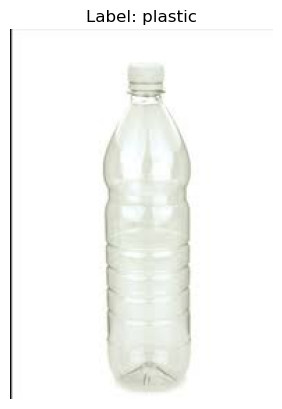

In [11]:
def display_images_with_labels(df, idx):
        row = df.iloc[idx]
        image_path = row['path']
        image_label = row['type_trash']
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(f'Label: {image_label}')
        plt.axis('off')
        plt.show()
        
display_images_with_labels(data, 1040)

## ****Model:**** <a class="anchor" id="chapter4"></a>
* First, the team has preprocessing and uses pure CNN to train the model. The results obtained are about ~80% accurate. When bringing this CNN model to the production environment, most of the tests give wrong results. Therefore, the team researched and consulted a number of papers with research on related topics. They will use new and better architectures to process images such as: VGG16, ResNet,...
* Therefore, the team will use some famous models for image classification to preprocess and train the model.
* After training and getting results, the team will compare loss and accuracy of each model to choose the most suitable model for serving and deploying the API.

### **Data Preprocessing:** <a class="anchor" id="subsection_4_1"></a>

* To use this model, we must first perform image preprocessing steps according to VGG16 requirements.
* Function `image_preprocessing`:
     * **Input:** img_path (path to image link)
     * **Output:** img (processed image)

In [12]:
from keras.applications.vgg16 import preprocess_input

def image_preprocessing(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img 

Steps to perform the above process include:
* Read images from image link `img_path` with standard size of `(224,224)` (VGG16 requires image input size to be 224x224).
* Convert the read image into an array. This array will contain information about the image's pixels. The size is `(224, 224, 3)`; where 3 means 3 RGB color channels.
* Expand the image size by 1 dimension => now the image will have the size `(1, 224, 224, 3)` $\rightarrow$ `tensor`.
* Finally, we use `preprocess_input` to convert the input image from RGB to BGR, then average each color channel.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


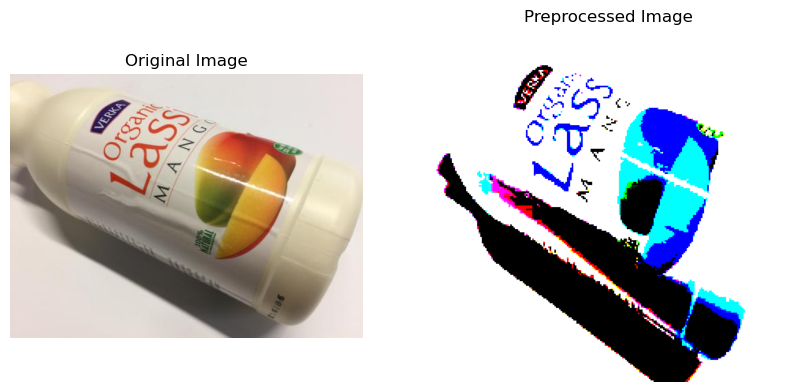

In [13]:
def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(np.squeeze(preprocessed, axis=0))
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')
    plt.show()

# Ubah path relatif menjadi path absolut
img_path = os.path.abspath('modified_dataset/plastic/plastic125.jpg')

# Pastikan path absolut mengarah ke file yang ada
if os.path.exists(img_path):
    original_image = Image.open(img_path)
    preprocessed_image = image_preprocessing(img_path)
    plot_images(original_image, preprocessed_image)
else:
    print("File tidak ditemukan:", img_path)

* As the above result, the image after preprocessing will have size 224x224. The image background will change to white and the colors of the objects in the image will also change.
*Performing the above process will cause all images in the dataset to be in the same size format. Besides, training data will give better results.